/tmp/ipykernel_10362/1186349522.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[idx])])


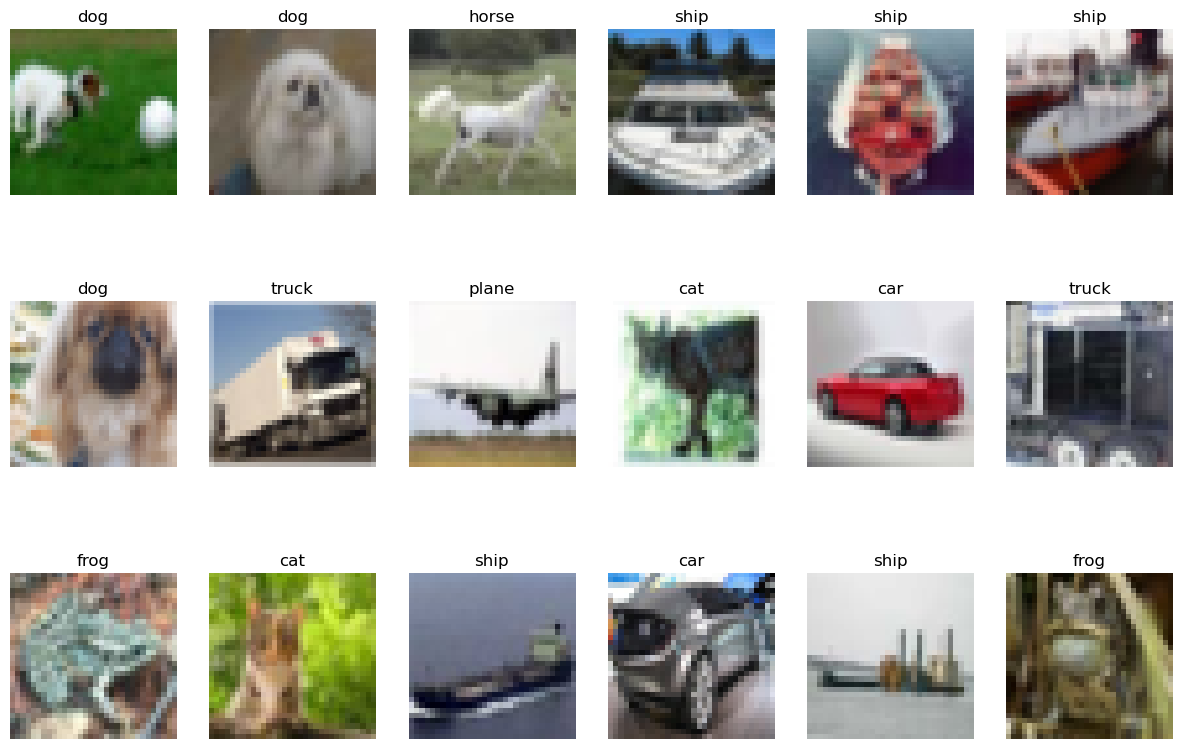

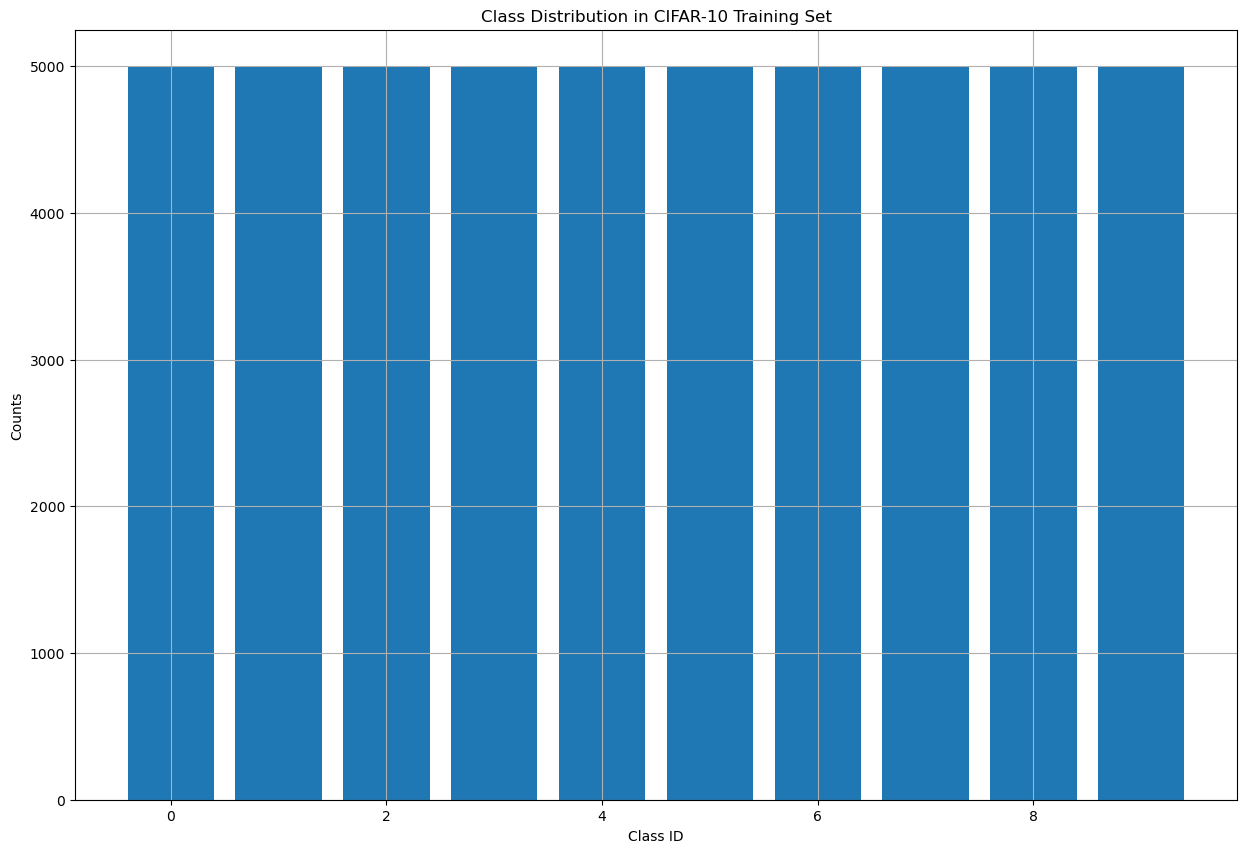

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 128)         73856     
____________________________________

2024-12-10 22:08:04.606630: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/25
391/391 [==============================] - 14s 36ms/step - loss: 1.6339 - accuracy: 0.4015 - val_loss: 1.4111 - val_accuracy: 0.4767
Epoch 2/25
391/391 [==============================] - 18s 45ms/step - loss: 1.2759 - accuracy: 0.5440 - val_loss: 1.2170 - val_accuracy: 0.5625
Epoch 3/25
391/391 [==============================] - 23s 60ms/step - loss: 1.1267 - accuracy: 0.6041 - val_loss: 1.1100 - val_accuracy: 0.6143
Epoch 4/25
391/391 [==============================] - 24s 61ms/step - loss: 1.0098 - accuracy: 0.6480 - val_loss: 1.0424 - val_accuracy: 0.6329
Epoch 5/25
391/391 [==============================] - 22s 57ms/step - loss: 0.9376 - accuracy: 0.6738 - val_loss: 1.0263 - val_accuracy: 0.6416
Epoch 6/25
391/391 [==============================] - 23s 58ms/step - loss: 0.8789 - accuracy: 0.6945 - val_loss: 0.9320 - val_accuracy: 0.6767
Epoch 7/25
391/391 [==============================] - 23s 58ms/step - loss: 0.8174 - accuracy: 0.7172 - val_loss: 0.9050 - val_accuracy:

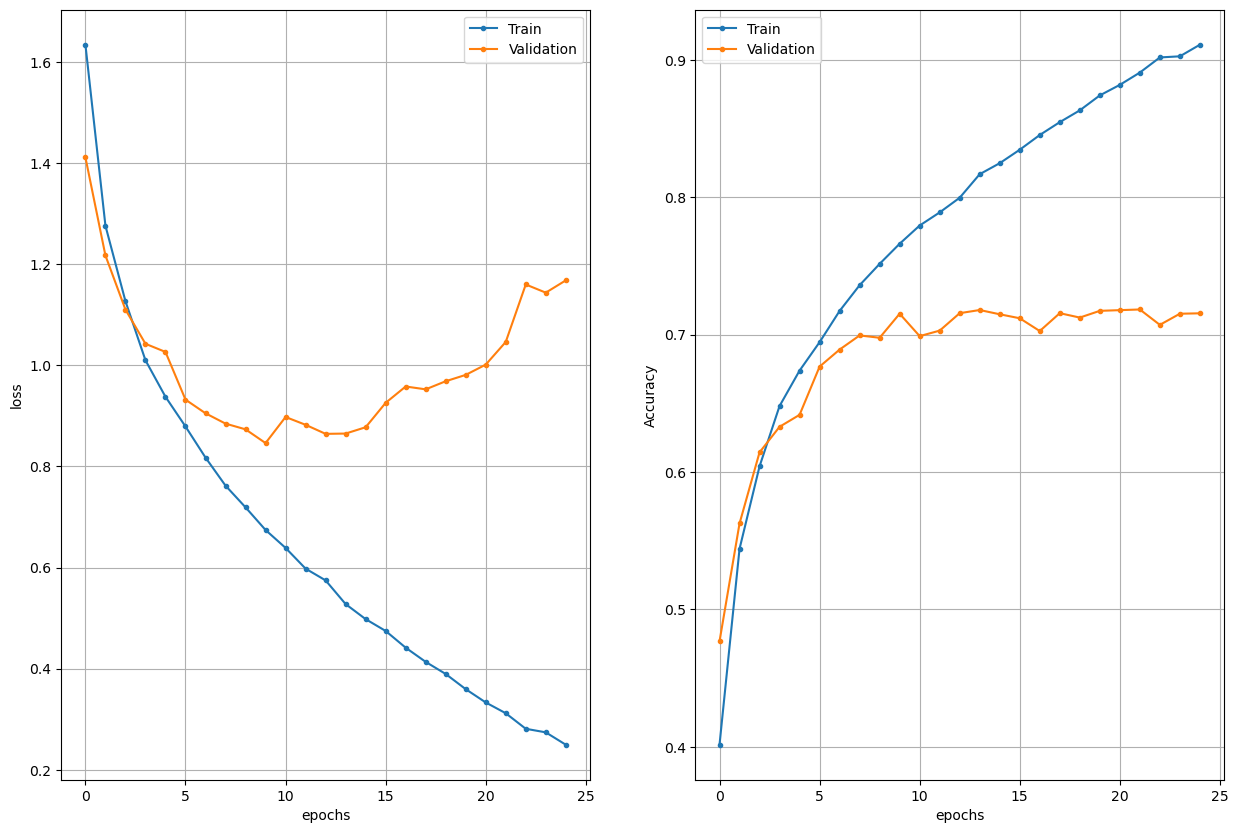

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.python.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0: 'plane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer',
           5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

# Dataset params
num_classes = len(classes)
size = x_train.shape[1]

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):
    plt.subplot(3, 6, ii+1)
    # Pick a random sample
    idx = np.random.randint(0, x_train.shape[0])
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])
    plt.axis('off')

plt.show()

# Compute the class histogram
from collections import Counter

hist = Counter(y_train.flatten())
plt.bar(hist.keys(), hist.values())
plt.grid(True)
plt.xlabel('Class ID')
plt.ylabel('Counts')
plt.title('Class Distribution in CIFAR-10 Training Set')
plt.show()

# Normalization
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

from tensorflow.python.keras.engine import data_adapter

def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset



# Build the classifier
inputs = Input(shape=(size, size, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Show the model
model.summary()


# Train the model
epochs = 25
batch_size = 128
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))
# history = model.fit(pixels, labels, epochs=10, batch_size=32)

# Show training history
h = history.history

epochs_range = range(len(h['loss']))

plt.subplot(121)
plt.plot(epochs_range, h['loss'], '.-', epochs_range, h['val_loss'], '.-')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'])

plt.subplot(122)
plt.plot(epochs_range, h['accuracy'], '.-', epochs_range, h['val_accuracy'], '.-')
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])


# Compute the labels and the predictions as sparse values
y_true = y_test.argmax(axis=1)
y_pred = model.predict(x_test).argmax(axis=-1)

# Compute and print the accuracy for each class
for class_id, class_name in classes.items():
    acc = np.mean(y_pred[y_true == class_id] == class_id)
    print(class_name, acc)

# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])




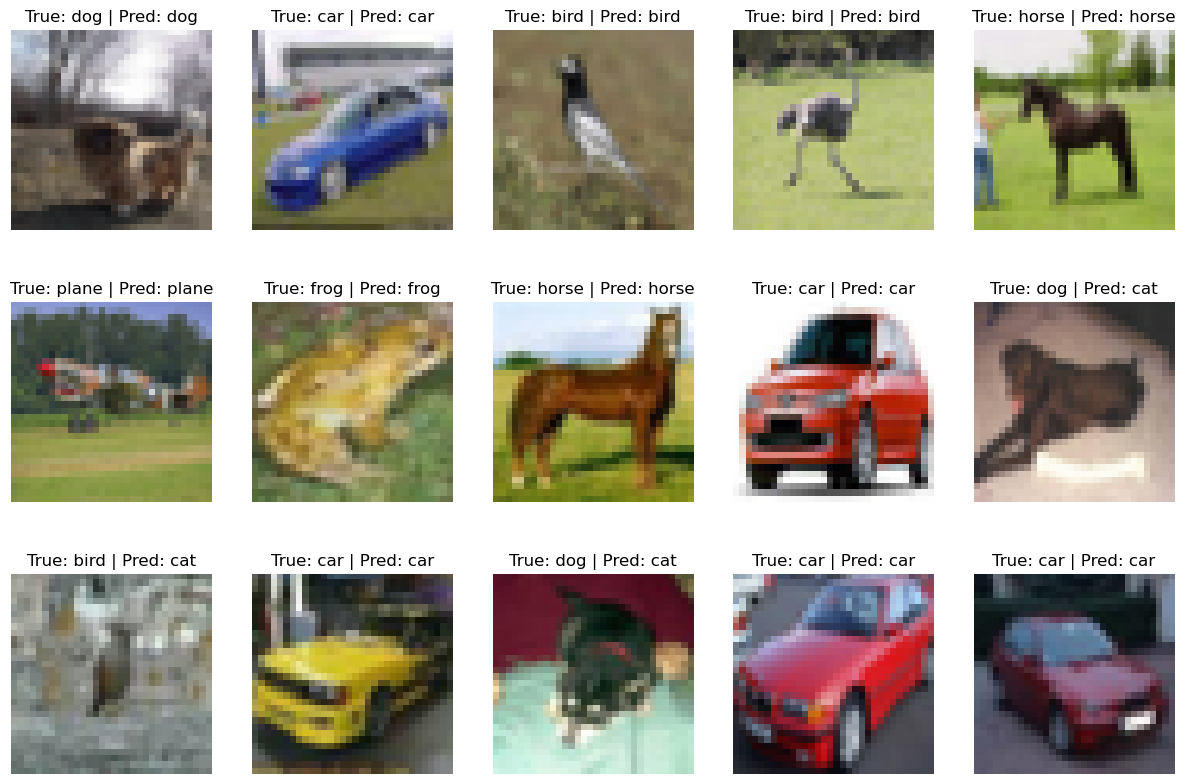

In [5]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, x_test.shape[0])
    # Show the results
    plt.subplot(3, 5, ii+1)
    plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))
    plt.axis('off')

plt.show()
